In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import collections
import pandas as pd
import numpy as np
import warnings
import re

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [7]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Dimensionality Reduction for Visualization
from sklearn.manifold import TSNE


In [9]:
warnings.filterwarnings(action = 'ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
N_TOP_WORDS = 20 

In [10]:
try:
    train_raw_df = pd.read_csv('/kaggle/input/cardataset/data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'cardataset.csv' not found. Make sure the file is in the correct directory.")
    exit()

Dataset loaded successfully.


In [11]:
print("\n--- Sample Data ---")
print(train_raw_df.head())


--- Sample Data ---
  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Performance  

In [12]:
print("\n--- DataFrame Info ---")
train_raw_df.info()


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dty

In [13]:
print("\n--- Preprocessing ---")
initial_rows = len(train_raw_df)
cols_to_check_na = ['Market Category', 'Vehicle Size', 'Vehicle Style', 'MSRP']
train_raw_df.dropna(subset=cols_to_check_na, inplace=True)
train_raw_df.reset_index(drop=True, inplace=True)
final_rows = len(train_raw_df)
print(f"Dropped {initial_rows - final_rows} rows containing NaNs in key columns.")
print(f"Shape after dropping NaNs: {train_raw_df.shape}")


--- Preprocessing ---
Dropped 3742 rows containing NaNs in key columns.
Shape after dropping NaNs: (8172, 16)



--- Visualizing Top Categories (Before Combining) ---


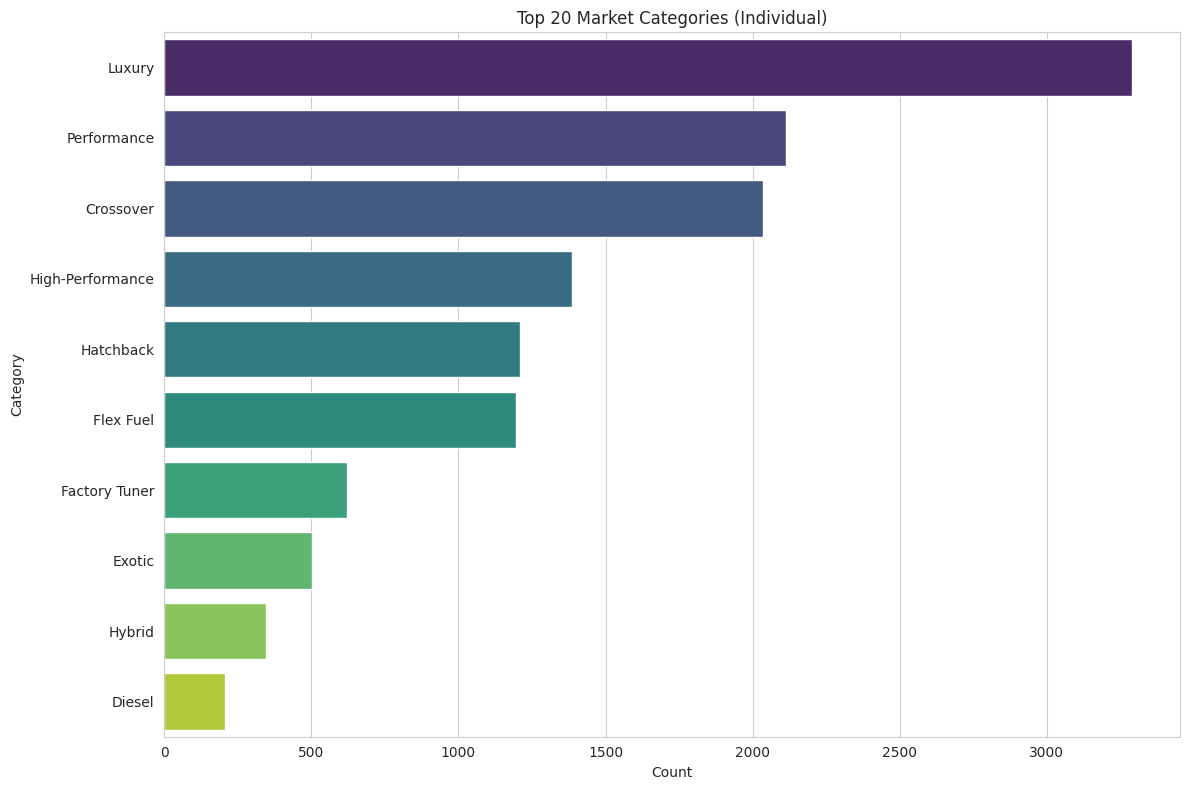

In [18]:
print(f"\n--- Visualizing Top Categories (Before Combining) ---")
text_source_columns = ['Market Category', 'Vehicle Size', 'Vehicle Style']
try:
    market_categories = train_raw_df['Market Category'].str.split(',').explode()
    market_categories = market_categories.str.strip()

    plt.figure(figsize=(12, 8))
    sns.countplot(y=market_categories, order=market_categories.value_counts().iloc[:N_TOP_WORDS].index, palette='viridis')
    plt.title(f'Top {N_TOP_WORDS} Market Categories (Individual)')
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not plot Market Category distribution: {e}")

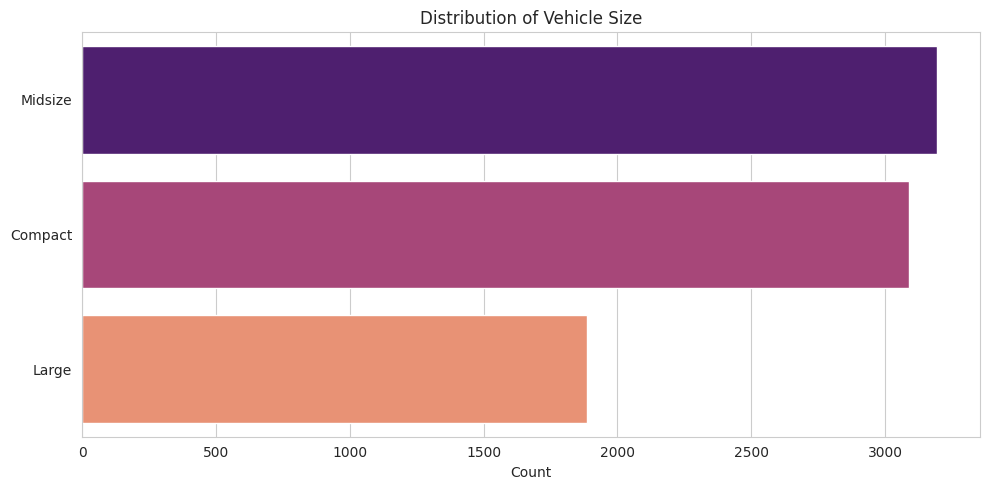

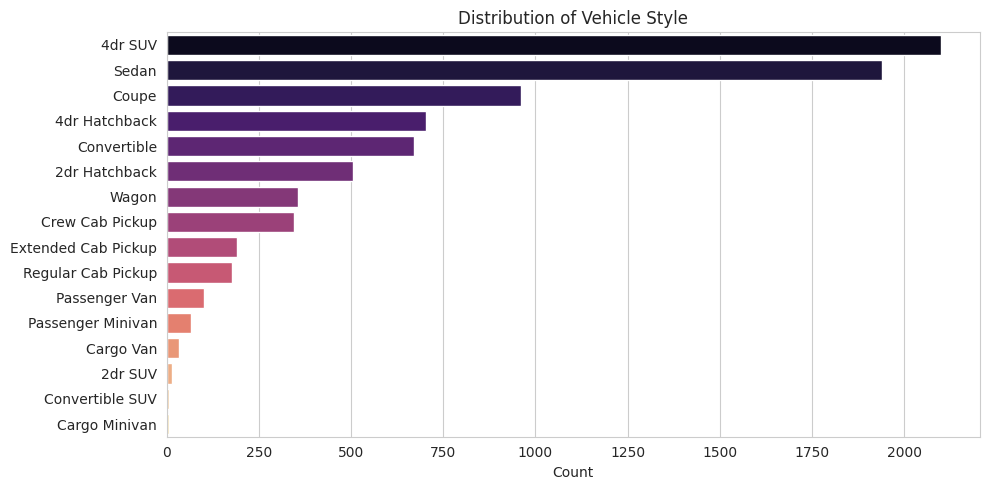

In [19]:
for col in ['Vehicle Size', 'Vehicle Style']:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train_raw_df, y=col, order=train_raw_df[col].value_counts().index, palette='magma')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel('') # Y label is clear from title
    plt.tight_layout()
    plt.show()

In [20]:
# --- Feature Engineering: Combine Text Columns ---
print("\n--- Feature Engineering: Creating 'train_text' ---")
train_raw_df["train_text"] = train_raw_df[text_source_columns].astype(str).apply(' '.join, axis=1)
print("Created 'train_text' column by joining:", text_source_columns)
print("Sample 'train_text':\n", train_raw_df["train_text"].head())


--- Feature Engineering: Creating 'train_text' ---
Created 'train_text' column by joining: ['Market Category', 'Vehicle Size', 'Vehicle Style']
Sample 'train_text':
 0    Factory Tuner,Luxury,High-Performance Compact ...
1               Luxury,Performance Compact Convertible
2                Luxury,High-Performance Compact Coupe
3                     Luxury,Performance Compact Coupe
4                           Luxury Compact Convertible
Name: train_text, dtype: object


In [22]:
x_train = train_raw_df["train_text"]
y_train = train_raw_df["MSRP"]

In [23]:
doc = " ".join(x_train)
print(f"\nLength of combined document 'doc': {len(doc)} characters")


Length of combined document 'doc': 271190 characters


In [24]:
# --- 1. CountVectorizer (Bag-of-Words) ---
print(f"\n--- 1. CountVectorizer (Top {N_TOP_WORDS} Words) ---")
count_vec = CountVectorizer(stop_words='english')
count_occurs = count_vec.fit_transform([doc])
words = count_vec.get_feature_names_out()
count_occur_df = pd.DataFrame({
    'Word': words,
    'Count': count_occurs.toarray().flatten() # Get counts
})
count_occur_df = count_occur_df.sort_values('Count', ascending=False).reset_index(drop=True)
print(count_occur_df.head(N_TOP_WORDS))


--- 1. CountVectorizer (Top 20 Words) ---
           Word  Count
0   performance   3501
1        luxury   3288
2       midsize   3195
3       compact   3090
4           4dr   2803
5     hatchback   2416
6           suv   2121
7     crossover   2034
8         sedan   1941
9         large   1887
10         high   1387
11         flex   1197
12         fuel   1197
13        coupe    960
14       pickup    711
15          cab    711
16  convertible    676
17      factory    621
18        tuner    621
19          2dr    520


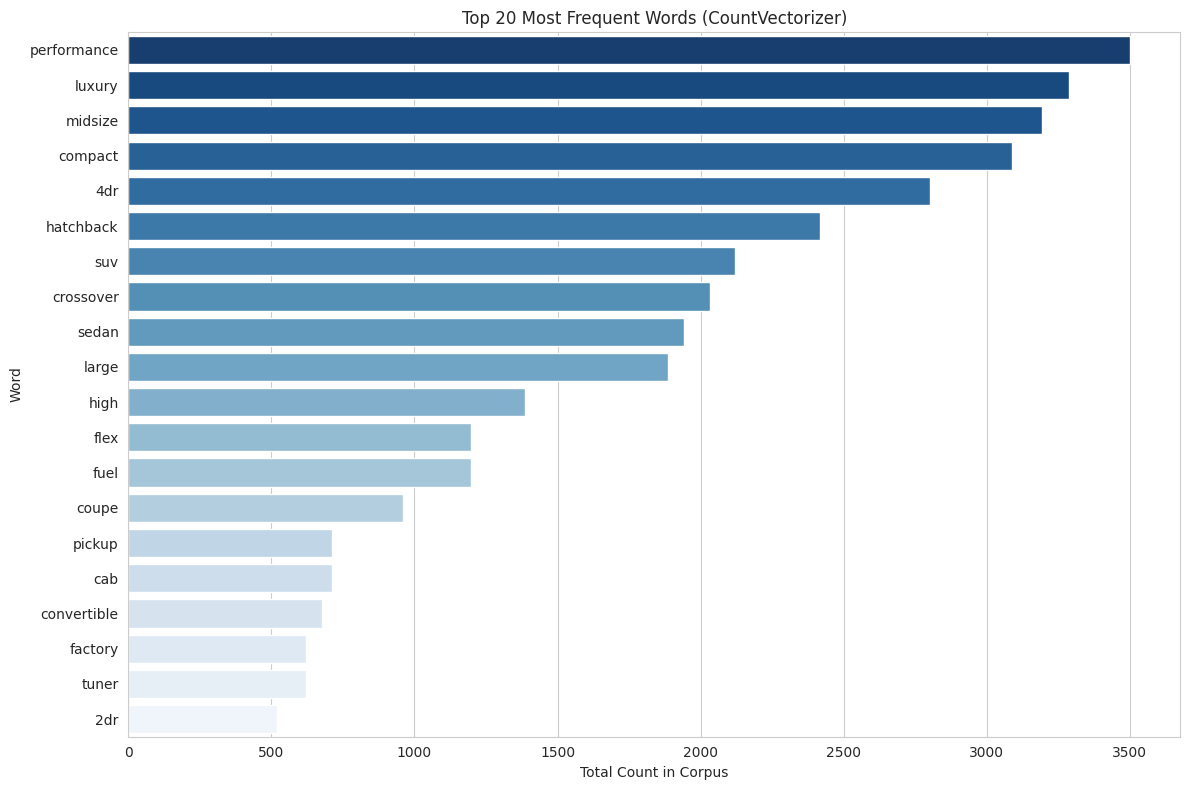

In [25]:
# Visualization for CountVectorizer
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=count_occur_df.head(N_TOP_WORDS), palette='Blues_r')
plt.title(f'Top {N_TOP_WORDS} Most Frequent Words (CountVectorizer)')
plt.xlabel('Total Count in Corpus')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

In [26]:
# --- 2. Normalized Count Occurrence ---
print(f"\n--- 2. Normalized Counts (L2 Norm, Top {N_TOP_WORDS} Words) ---")
norm_count_vec = TfidfVectorizer(use_idf=False, norm='l2', stop_words='english')
norm_count_occurs = norm_count_vec.fit_transform([doc])
norm_words = norm_count_vec.get_feature_names_out()
norm_count_occur_df = pd.DataFrame({
    'Word': norm_words,
    'NormalizedCount_L2': norm_count_occurs.toarray().flatten()
})
norm_count_occur_df = norm_count_occur_df.sort_values('NormalizedCount_L2', ascending=False).reset_index(drop=True)
print(norm_count_occur_df.head(N_TOP_WORDS))


--- 2. Normalized Counts (L2 Norm, Top 20 Words) ---
           Word  NormalizedCount_L2
0   performance            0.387849
1        luxury            0.364253
2       midsize            0.353950
3       compact            0.342318
4           4dr            0.310523
5     hatchback            0.267650
6           suv            0.234970
7     crossover            0.225331
8         sedan            0.215029
9         large            0.209046
10         high            0.153655
11         flex            0.132607
12         fuel            0.132607
13        coupe            0.106351
14       pickup            0.078766
15          cab            0.078766
16  convertible            0.074889
17      factory            0.068796
18        tuner            0.068796
19          2dr            0.057607


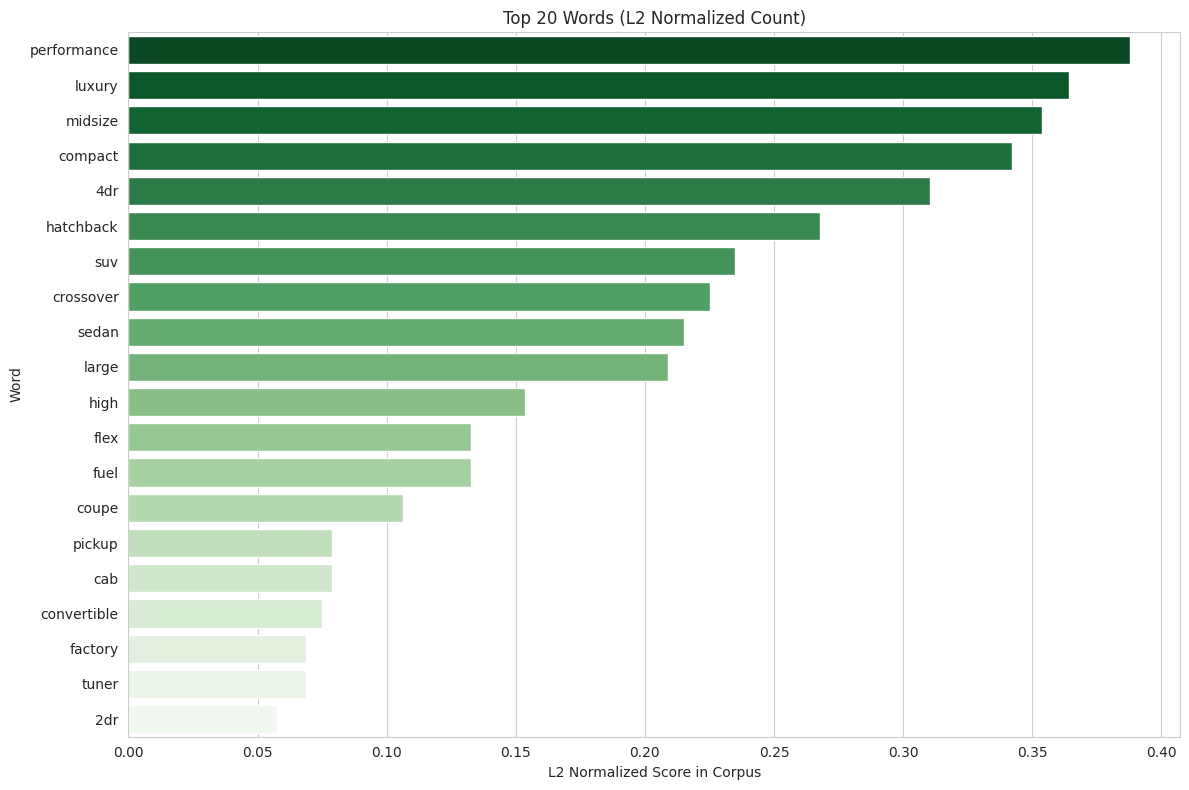

In [27]:
# Visualization for Normalized Counts
plt.figure(figsize=(12, 8))
sns.barplot(x='NormalizedCount_L2', y='Word', data=norm_count_occur_df.head(N_TOP_WORDS), palette='Greens_r')
plt.title(f'Top {N_TOP_WORDS} Words (L2 Normalized Count)')
plt.xlabel('L2 Normalized Score in Corpus')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

In [28]:
# --- 3. TF-IDF ---
print(f"\n--- 3. TF-IDF (Top {N_TOP_WORDS} Words) ---")
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_count_occurs = tfidf_vec.fit_transform([doc])
tfidf_words = tfidf_vec.get_feature_names_out()
tfidf_occur_df = pd.DataFrame({
    'Word': tfidf_words,
    'TFIDF_Score': tfidf_count_occurs.toarray().flatten()
})
tfidf_occur_df = tfidf_occur_df.sort_values('TFIDF_Score', ascending=False).reset_index(drop=True)
print(tfidf_occur_df.head(N_TOP_WORDS))


--- 3. TF-IDF (Top 20 Words) ---
           Word  TFIDF_Score
0   performance     0.387849
1        luxury     0.364253
2       midsize     0.353950
3       compact     0.342318
4           4dr     0.310523
5     hatchback     0.267650
6           suv     0.234970
7     crossover     0.225331
8         sedan     0.215029
9         large     0.209046
10         high     0.153655
11         flex     0.132607
12         fuel     0.132607
13        coupe     0.106351
14       pickup     0.078766
15          cab     0.078766
16  convertible     0.074889
17      factory     0.068796
18        tuner     0.068796
19          2dr     0.057607


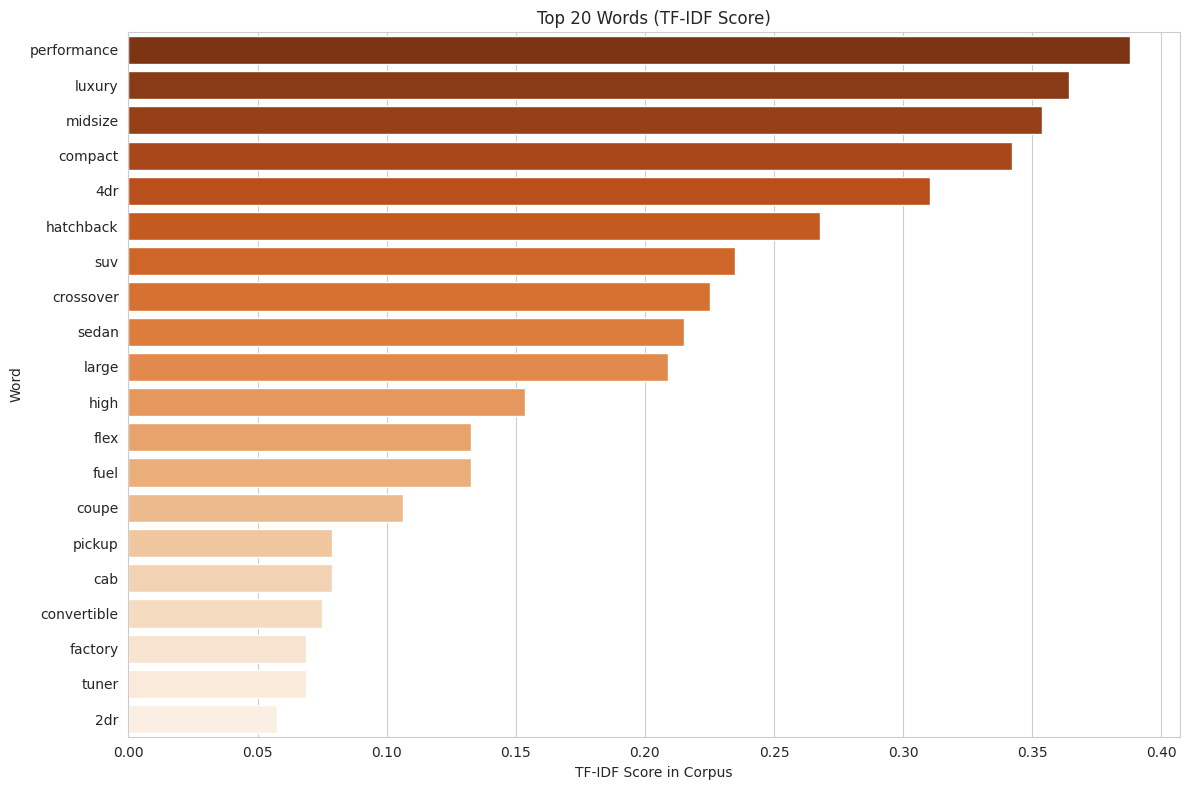

In [29]:
# Visualization for TF-IDF
plt.figure(figsize=(12, 8))
sns.barplot(x='TFIDF_Score', y='Word', data=tfidf_occur_df.head(N_TOP_WORDS), palette='Oranges_r')
plt.title(f'Top {N_TOP_WORDS} Words (TF-IDF Score)')
plt.xlabel('TF-IDF Score in Corpus')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

In [30]:
# --- 4. Word2Vec ---
print("\n--- 4. Word2Vec Embeddings ---")
print("Tokenizing sentences for Word2Vec...")
data_for_w2v = []
for text_entry in x_train:
    temp = []
    cleaned_entry = re.sub(r'\W+', ' ', text_entry.lower())
    for word in word_tokenize(cleaned_entry):
        if word.isalpha() and len(word) > 1:
             temp.append(word)
    if temp:
        data_for_w2v.append(temp)

print(f"Prepared {len(data_for_w2v)} sequences for Word2Vec.")
print("Sample tokenized sequence:", data_for_w2v[0])


--- 4. Word2Vec Embeddings ---
Tokenizing sentences for Word2Vec...
Prepared 8172 sequences for Word2Vec.
Sample tokenized sequence: ['factory', 'tuner', 'luxury', 'high', 'performance', 'compact', 'coupe']


In [33]:
# Word2Vec Parameters
VECTOR_SIZE = 100
WINDOW = 5
MIN_COUNT = 5 # Increased min_count to focus on more common words
WORKERS = 4 # Use multiple cores if available

In [34]:
print("\nTraining Word2Vec CBOW model...")
model_cbow = gensim.models.Word2Vec(data_for_w2v,
                                    vector_size=VECTOR_SIZE,
                                    window=WINDOW,
                                    min_count=MIN_COUNT,
                                    workers=WORKERS,
                                    sg=0)
print("CBOW model trained.")

print("\n--- CBOW Similarities ---")
try:
    similarity_lux_perf_cbow = model_cbow.wv.similarity('luxury', 'performance')
    print(f"Cosine similarity between 'luxury' and 'performance' (CBOW): {similarity_lux_perf_cbow:.4f}")
except KeyError as e:
    print(f"Could not calculate CBOW similarity for 'luxury'/'performance': {e} (Word might be below min_count)")

try:
    similarity_cross_mid_cbow = model_cbow.wv.similarity('crossover', 'midsize')
    print(f"Cosine similarity between 'crossover' and 'midsize' (CBOW): {similarity_cross_mid_cbow:.4f}")
except KeyError as e:
    print(f"Could not calculate CBOW similarity for 'crossover'/'midsize': {e} (Word might be below min_count)")


Training Word2Vec CBOW model...
CBOW model trained.

--- CBOW Similarities ---
Cosine similarity between 'luxury' and 'performance' (CBOW): 0.9817
Cosine similarity between 'crossover' and 'midsize' (CBOW): 0.8863


In [35]:
print("\nTraining Word2Vec Skip-Gram model...")
model_skipgram = gensim.models.Word2Vec(data_for_w2v,
                                        vector_size=VECTOR_SIZE,
                                        window=WINDOW,
                                        min_count=MIN_COUNT,
                                        workers=WORKERS,
                                        sg=1) 
print("Skip-Gram model trained.")

print("\n--- Skip-Gram Similarities ---")
try:
    similarity_lux_perf_sg = model_skipgram.wv.similarity('luxury', 'performance')
    print(f"Cosine similarity between 'luxury' and 'performance' (Skip-Gram): {similarity_lux_perf_sg:.4f}")
except KeyError as e:
    print(f"Could not calculate Skip-Gram similarity for 'luxury'/'performance': {e} (Word might be below min_count)")

try:
    similarity_cross_mid_sg = model_skipgram.wv.similarity('crossover', 'midsize')
    print(f"Cosine similarity between 'crossover' and 'midsize' (Skip-Gram): {similarity_cross_mid_sg:.4f}")
except KeyError as e:
    print(f"Could not calculate Skip-Gram similarity for 'crossover'/'midsize': {e} (Word might be below min_count)")


Training Word2Vec Skip-Gram model...
Skip-Gram model trained.

--- Skip-Gram Similarities ---
Cosine similarity between 'luxury' and 'performance' (Skip-Gram): 0.9859
Cosine similarity between 'crossover' and 'midsize' (Skip-Gram): 0.8885


In [37]:
# --- Visualize Word Embeddings using t-SNE ---
print("\n--- Visualizing Word Embeddings (t-SNE) ---")

def plot_tsne(model, words_to_plot, title):
    try:
        word_vectors = np.array([model.wv[word] for word in words_to_plot])
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words_to_plot)-1)) # Adjust perplexity if needed
        vectors_2d = tsne.fit_transform(word_vectors)
        
        # Create plot
        plt.figure(figsize=(14, 10))
        sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], s=50) # Use s for point size
        
        # Annotate points
        for i, word in enumerate(words_to_plot):
            plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=9)
            
        plt.title(title, fontsize=16)
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.grid(True)
        plt.show()
        
    except KeyError as e:
        print(f"Error during t-SNE plotting for {title}: {e}. A word might not be in the model's vocabulary (check min_count).")
    except Exception as e:
        print(f"An unexpected error occurred during t-SNE plotting for {title}: {e}")

vocab_cbow = list(model_cbow.wv.index_to_key)
top_words_in_cbow_vocab = [word for word in count_occur_df['Word'] if word in vocab_cbow][:N_TOP_WORDS + 10] # Get a few extra

vocab_skipgram = list(model_skipgram.wv.index_to_key)
top_words_in_skipgram_vocab = [word for word in count_occur_df['Word'] if word in vocab_skipgram][:N_TOP_WORDS + 10]




--- Visualizing Word Embeddings (t-SNE) ---


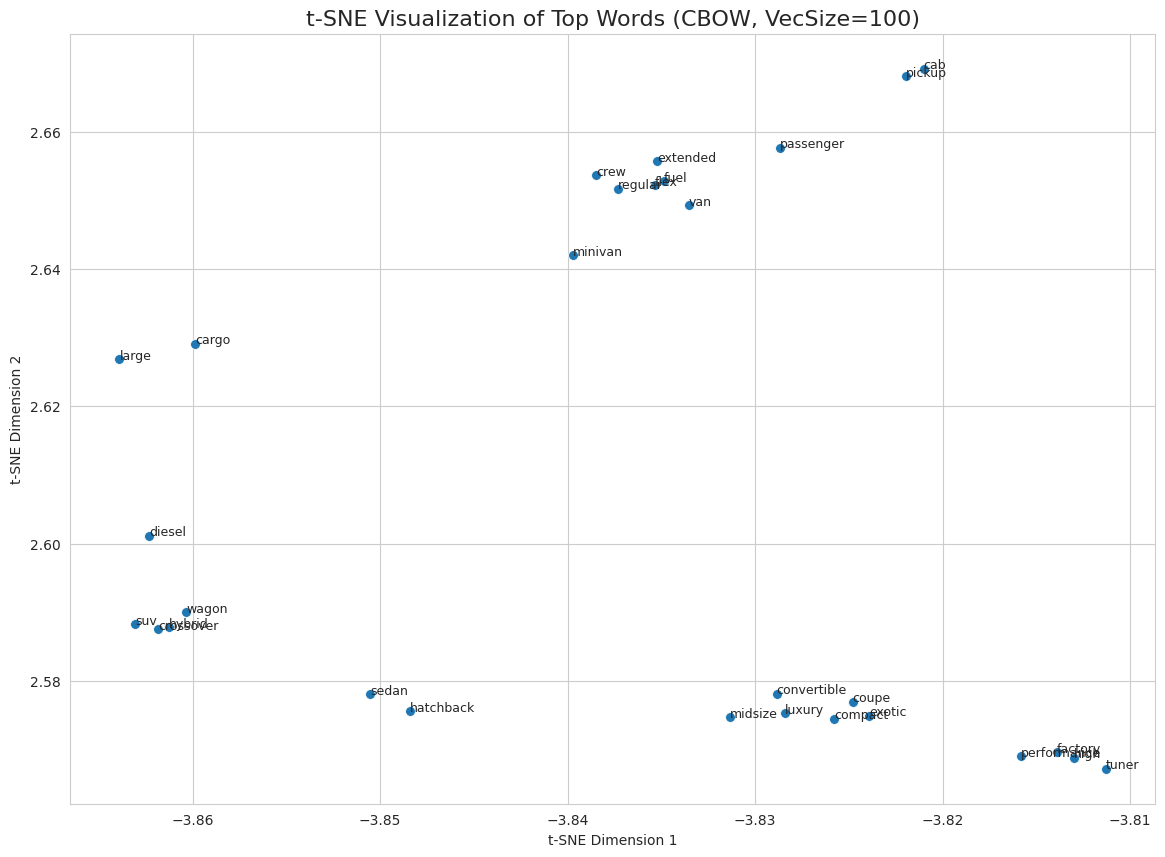

In [39]:
# Plot for CBOW
if top_words_in_cbow_vocab:
    plot_tsne(model_cbow, top_words_in_cbow_vocab, f't-SNE Visualization of Top Words (CBOW, VecSize={VECTOR_SIZE})')
else:
    print("No words from the top frequency list found in CBOW vocabulary to plot.")

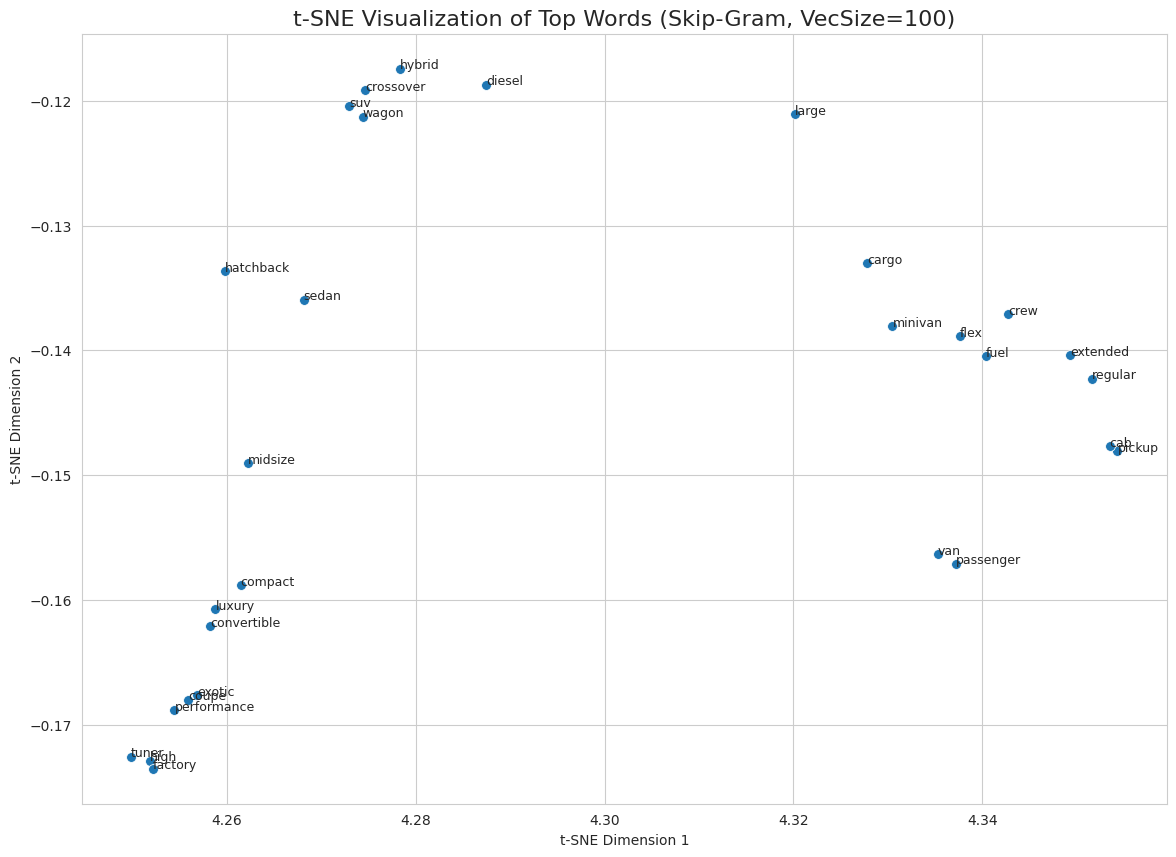

In [40]:
# Plot for Skip-Gram
if top_words_in_skipgram_vocab:
    plot_tsne(model_skipgram, top_words_in_skipgram_vocab, f't-SNE Visualization of Top Words (Skip-Gram, VecSize={VECTOR_SIZE})')
else:
    print("No words from the top frequency list found in Skip-Gram vocabulary to plot.")